### Fine-tuning and Transfer Learning

This notebook uses content from [Tensorflow transfer learning tutorial](https://www.tensorflow.org/guide/keras/transfer_learning) and [Tensorflow image classification tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [ ]:
!nvidia-smi

Wed Mar 26 20:54:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Image classification

This tutorial shows how to classify images of flowers. It creates an image classifier using a `tf.keras` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Keras Functional and Sequential API.
* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [ ]:
!pip install visualkeras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 13.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
import visualkeras

In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
data_dir = data_dir / "flower_photos"

In [ ]:
!ls /root/.keras/datasets/flower_photos/

flower_photos


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

In [ ]:
roses = list(data_dir.glob('roses/*'))
img = PIL.Image.open(str(roses[4]))

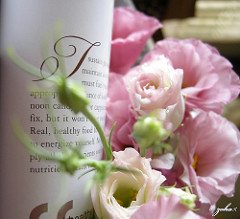

In [ ]:
img

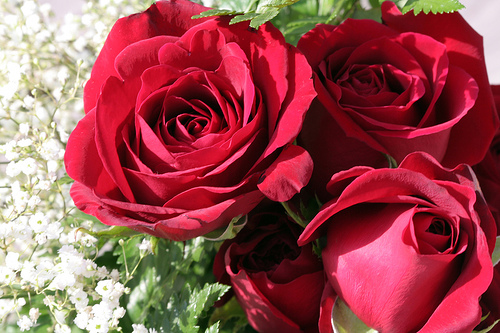

In [ ]:
PIL.Image.open(str(roses[100]))

And some tulips:

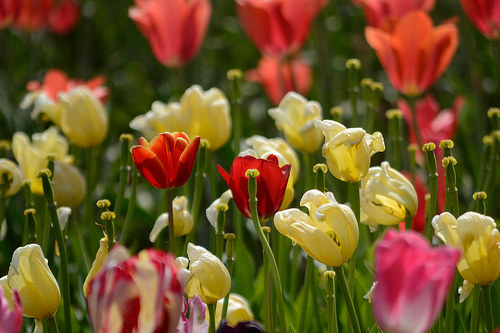

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

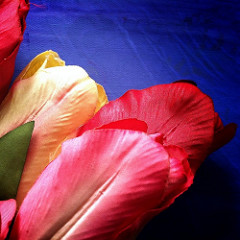

In [ ]:
PIL.Image.open(str(tulips[1]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred", # Get the class name from the sub-dir names
    label_mode="categorical", # Represent label as one-hot e.g. [0, 0, 0, 1, 0]
    validation_split=0.2, # 20% for test
    subset="both", # get both subsets
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

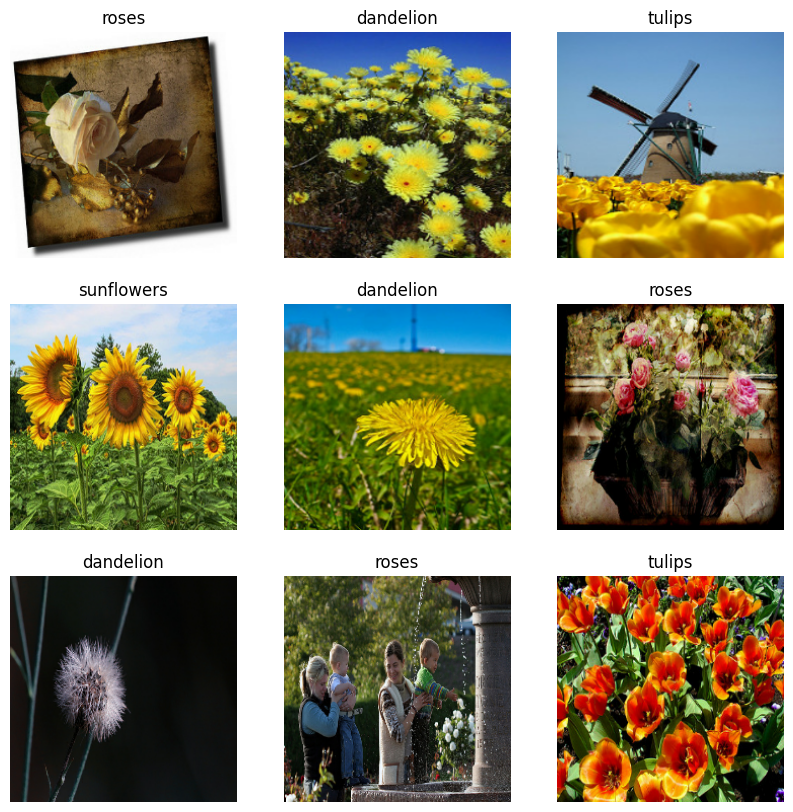

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 5)


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## The typical transfer-learning workflow

A typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting `trainable = False`.
3. Create a new model on top of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.


In [ ]:
# Instantiate a base model with pre-trained weights.
base_model = keras.applications.resnet.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,  # we exclude the final layer
    #pooling='avg',
    )  # Do not include the ImageNet classifier at the top.

base_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
base_model.save("resnet50.keras")

In [ ]:
base_model = keras.models.load_model("resnet50.keras")

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


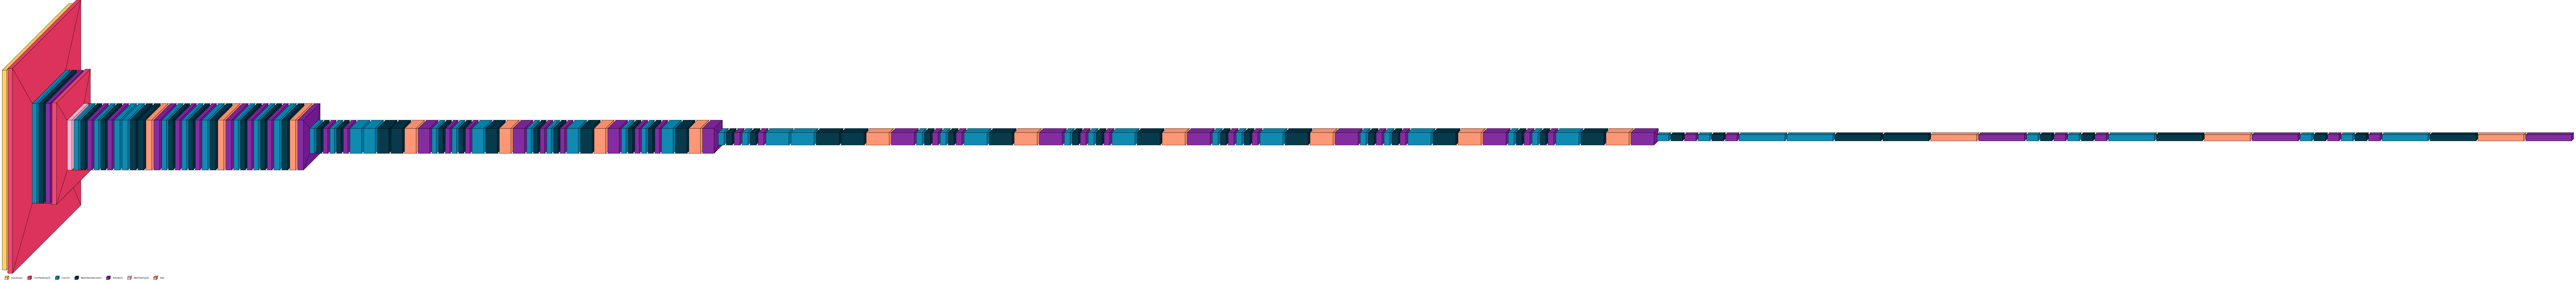

In [ ]:
visualkeras.layered_view(base_model, legend=True)

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

# Let's extract convolutional layers where filter sizes are larger than 1x1
conv_layers = { layer.name: i for i, layer in enumerate(base_model.layers) if layer.name.endswith('conv') and layer.weights[0].shape[0] > 1}


@interact
def show_filters(layer=widgets.Select(options=conv_layers)):

    # [0] is to extract the kernel weights, [1] is for the biases
    weights = base_model.layers[layer].weights[0].value.numpy()

    filter_size = weights.shape[0]
    weights_min = np.min(weights, axis=(2,3))
    weights_min = weights_min.reshape(filter_size, filter_size, 1, 1)
    weights_max = np.max(weights, axis=(2,3))
    weights_max = weights_max.reshape(filter_size, filter_size, 1, 1)
    weights_scaled = (weights - weights_min) / (weights_max - weights_min)

    # print(weights.shape)

    if layer == 2:
        fig, ax = plt.subplots(2, 16, figsize=(16,4))
        for i in range(2):
            for j in range(16):
                ax[i,j].imshow(weights_scaled[:,:,:,i*16+j])
                ax[i,j].axis('off')
    else:
        fig, ax = plt.subplots(16, 16, figsize=(16,16))
        for i in range(16):
            for j in range(16):
                ax[i,j].imshow(weights_scaled[:,:,i,j], cmap='gray')
                ax[i,j].axis('off')
    fig.tight_layout()
    fig.show();

interactive(children=(Select(description='layer', options={'conv1_conv': 2, 'conv2_block1_2_conv': 10, 'conv2_…

In [ ]:
# Then, freeze the base model.
base_model.trainable = False

# Create a new model on top.
inputs = keras.Input(shape=(img_height, img_width, 3))

# We must add the corresponding image pre-processing
x = keras.applications.resnet50.preprocess_input(inputs)

# Add the pre-trained model here
x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a 5 output classes
outputs = keras.layers.Dense(5, activation='softmax')(x)

# Final model
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 5)              │         10,245 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the model on new data.
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.6181 - loss: 1.0517 - val_accuracy: 0.8869 - val_loss: 0.3296
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9106 - loss: 0.2778 - val_accuracy: 0.9005 - val_loss: 0.2734
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9368 - loss: 0.2090 - val_accuracy: 0.9087 - val_loss: 0.2430
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.9606 - loss: 0.1515 - val_accuracy: 0.9019 - val_loss: 0.2592
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9660 - loss: 0.1291 - val_accuracy: 0.9210 - val_loss: 0.2361
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.9779 - loss: 0.1051 - val_accuracy: 0.9101 - val_loss: 0.2280
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9852 - loss: 0.0835 - val_accuracy: 0.9155 - val_loss: 0.2259
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 5.


### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.5),
    ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

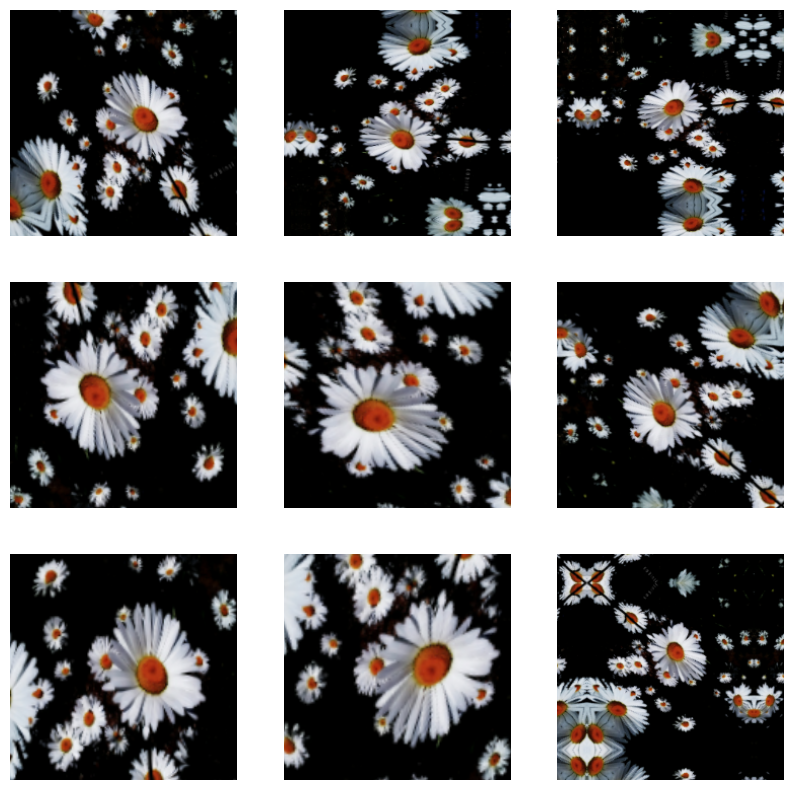

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
# Instantiate a base model with pre-trained weights.
base_model = keras.applications.resnet.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Then, freeze the base model.
base_model.trainable = False

# Create a new model on top.
inputs = keras.Input(shape=(img_height, img_width, 3))

# Apply Data augmentation on input images
x = data_augmentation(inputs)

# We must add the corresponding image pre-processing
x = keras.applications.resnet50.preprocess_input(x)

# Add the pre-trained model here
x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# Add dropout
x = layers.Dropout(0.5)(x)

# A Dense classifier with a 5 output classes
outputs = keras.layers.Dense(5, kernel_regularizer='l2', activation='softmax')(x)

# Final model
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5)              │         10,245 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the model on new data.
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - accuracy: 0.4468 - loss: 1.6846 - val_accuracy: 0.8569 - val_loss: 0.5363
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.7698 - loss: 0.7479 - val_accuracy: 0.8774 - val_loss: 0.4504
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.7910 - loss: 0.6597 - val_accuracy: 0.8692 - val_loss: 0.4397
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - accuracy: 0.8306 - loss: 0.5433 - val_accuracy: 0.8896 - val_loss: 0.4003
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.8323 - loss: 0.5359 - val_accuracy: 0.8924 - val_loss: 0.3837
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - accuracy: 0.8569 - loss: 0.4887 - val_accuracy: 0.9033 - val_loss: 0.3789
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.8511 - loss: 0.4983 - val_accuracy: 0.9060 - val_loss: 0.3602
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.8310 - loss: 0.5279 - val_accu

## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.


In [ ]:
# Unfreeze the base_model
base_model.trainable = True
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5)              │         10,245 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,618,449 (90.10 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 20,492 (80.05 KB)

In [ ]:
# Train the entire model, use a low learning rate
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer_model = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 606ms/step - accuracy: 0.7944 - loss: 0.6633 - val_accuracy: 0.9074 - val_loss: 0.3319
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 562ms/step - accuracy: 0.8625 - loss: 0.4458 - val_accuracy: 0.9169 - val_loss: 0.3111
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 552ms/step - accuracy: 0.8783 - loss: 0.4099 - val_accuracy: 0.9169 - val_loss: 0.2962
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 554ms/step - accuracy: 0.9013 - loss: 0.3554 - val_accuracy: 0.9169 - val_loss: 0.2823
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


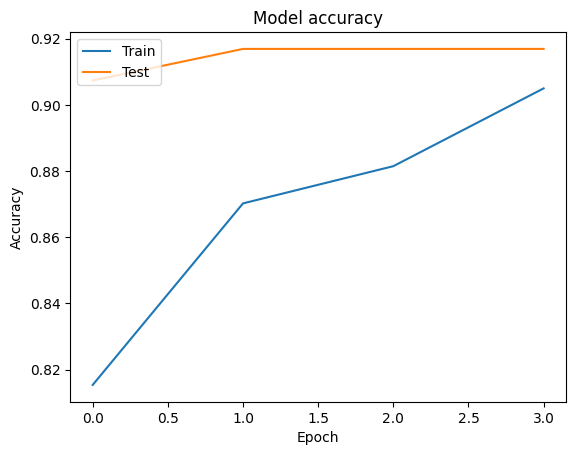

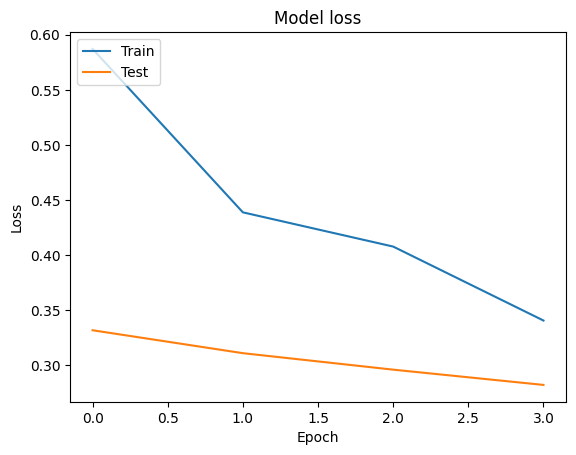

In [ ]:
plot_history(history_transfer_model)

## Versus fine-tuning the entire model from the beginning

In [ ]:
# 1. Instantiate a base model with pre-trained weights.
base_model = keras.applications.resnet.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# 2. Then, freeze the base model.
base_model.trainable = True

# 3. Create a new model on top.
inputs = keras.Input(shape=(img_height, img_width, 3))

# Apply Data augmentation on input images
x = data_augmentation(inputs)

# We must add the corresponding image pre-processing
x = keras.applications.resnet50.preprocess_input(x)

# Add the pre-trained model here
x = base_model(x, training=True)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# Add dropout
x = layers.Dropout(0.5)(x)

# A Dense classifier with a 5 output classes
outputs = keras.layers.Dense(5, activation='softmax')(x)

# Final model
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_8 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_6[0][0],      │
│                           │                        │                │ get_item_7[0][0],      │
│                           │                        │                │ get_item_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 5)              │         10,245 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Train the entire model, use a low learning rate
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_model = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 589ms/step - accuracy: 0.6136 - loss: 1.0528 - val_accuracy: 0.9074 - val_loss: 0.4618
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 555ms/step - accuracy: 0.8963 - loss: 0.2719 - val_accuracy: 0.9223 - val_loss: 0.2423
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 560ms/step - accuracy: 0.9149 - loss: 0.2440 - val_accuracy: 0.9332 - val_loss: 0.2342
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 560ms/step - accuracy: 0.9394 - loss: 0.1723 - val_accuracy: 0.9128 - val_loss: 0.2474
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 578ms/step - accuracy: 0.9594 - loss: 0.1374 - val_accuracy: 0.9155 - val_loss: 0.3205
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


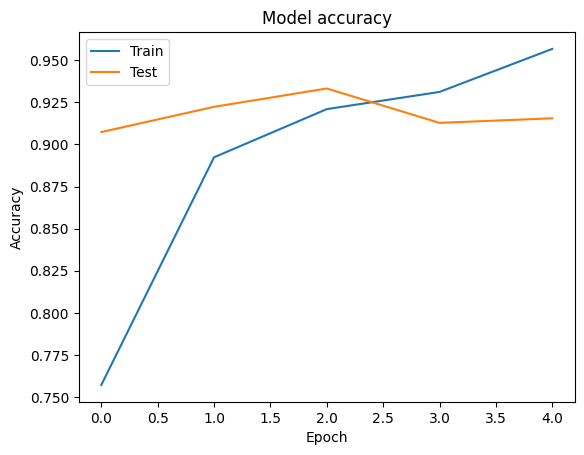

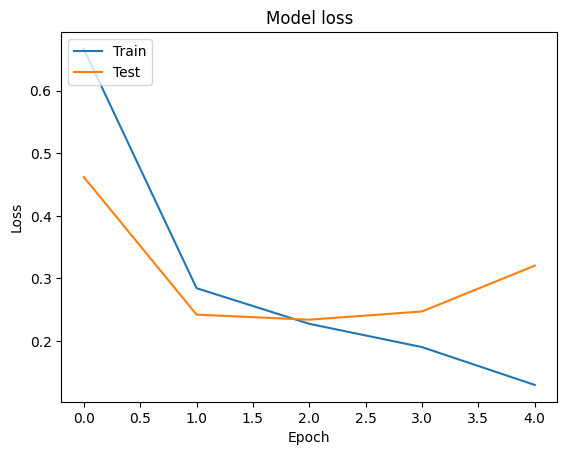

In [ ]:
plot_history(history_model)